In [1]:
import os
HOME = os.getcwd()
print(HOME)


/content


In [18]:
!mkdir {HOME}/images
!mkdir {HOME}/dataset

mkdir: cannot create directory ‘/content/images’: File exists
mkdir: cannot create directory ‘/content/dataset’: File exists


In [3]:
!pip install autodistill==0.1.28  autodistill-detr autodistill-grounding-dino supervision roboflow


In [4]:
!pip install opencv-python-headless


In [5]:
IMAGE_DIR_PATH = f"{HOME}/images"
DATASET_DIR_PATH = f"{HOME}/dataset"


In [6]:
import cv2

video_path = f"{HOME}/vid.mp4"  # Replace with the name of your uploaded video
output_dir = IMAGE_DIR_PATH  # Directory to save frames
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames in video

print(f"Total Frames: {frame_count}, FPS: {frame_rate}")

frame_number = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Save every Nth frame (e.g., 1 frame per second)
    if frame_number % 3 == 0:  # Change this logic if needed
        frame_filename = os.path.join(output_dir, f"img_{frame_number:03d}.jpg")
        cv2.imwrite(frame_filename, frame)

    frame_number += 1

cap.release()
print(f"Frames saved to {output_dir}")

Total Frames: 620, FPS: 30
Frames saved to /content/images


In [7]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg"])  # Ensure 'jpg' is listed only once

print('image count:', len(image_paths))

image count: 207


In [8]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

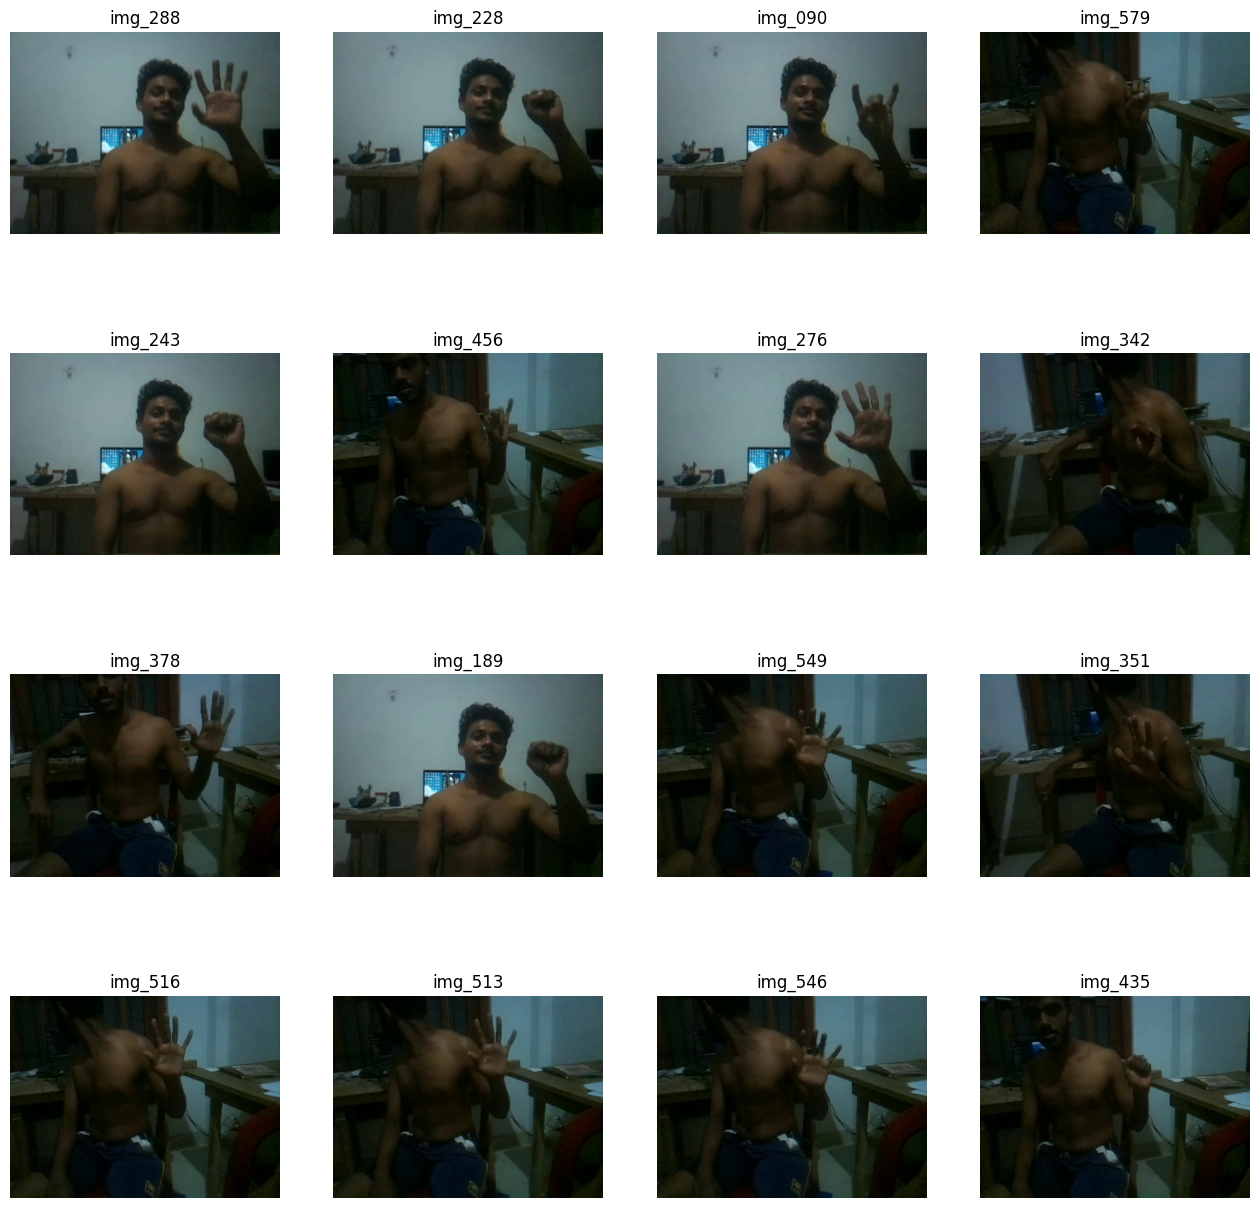

In [9]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [10]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
import os
import cv2
import supervision as sv





base_model = GroundingDINO(ontology=CaptionOntology({"hand": "hand"}))



a = sv.BoxAnnotator()
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)


Importing from timm.models.layers is deprecated, please import via timm.layers


trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Labeled dataset created - ready for distillation.


In [11]:
import supervision as sv

ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"
len(dataset)

207

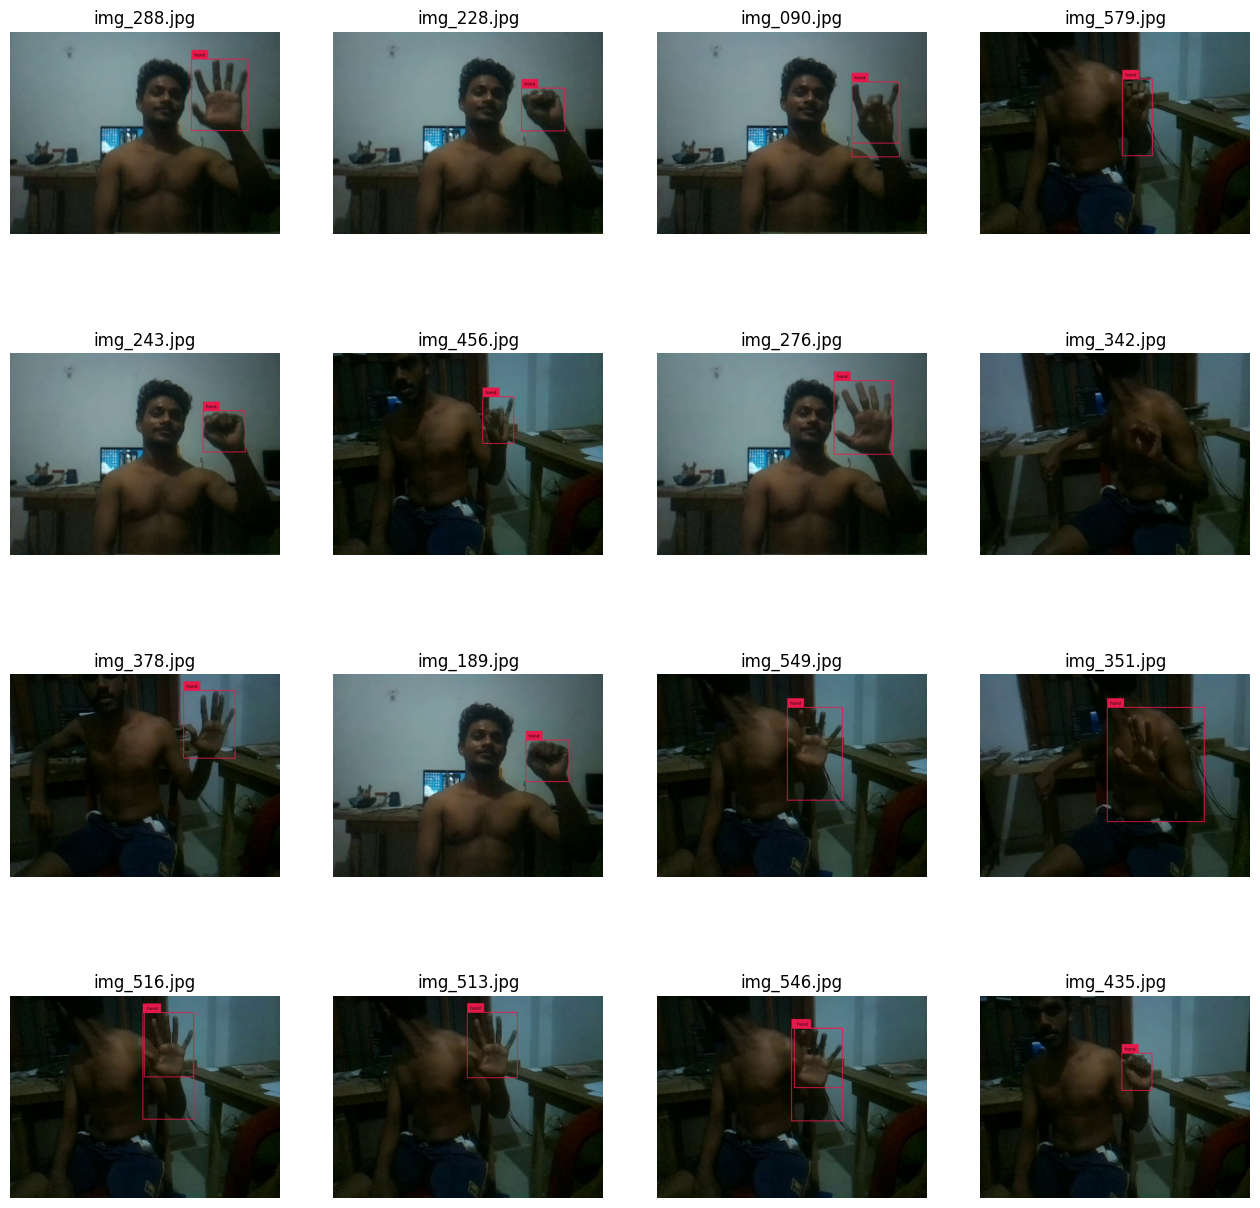

In [12]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install ultralytics

In [15]:
!yolo task=detect mode=train model=yolov10n.pt data=/content/dataset/data.yaml epochs=100 imgsz=240 plots=True


100% 5.59M/5.59M [00:00<00:00, 258MB/s]
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

In [18]:
!yolo task=detect mode=predict model=/content/best.pt conf=0.25 source='/content/images/img_114.jpg' save=True


Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/images/img_114.jpg: 320x416 1 hand, 83.1ms
Speed: 5.6ms preprocess, 83.1ms inference, 36.7ms postprocess per image at shape (1, 3, 320, 416)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [1]:
from ultralytics import YOLO
model = YOLO("/content/runs/detect/train/weights/best.pt")
model.export(format="tflite")

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 256, 256) BCHW and output shape(s) (1, 300, 6) (5.4 MB)
requirements: Ultralytics requirement ['onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 315.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.1s, installed 1 package: ['onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.18.0...

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 4.9s, saved as '/content/runs/detect/train/weights/best.onnx' (8.8 MB)
TensorFlow SavedModel: starting TFLit

'/content/runs/detect/train/weights/best_saved_model/best_float32.tflite'